# <center> CLASIFICACIÓN DE IMÁGENES: CELEBRIDADES EN EL DEPORTE </center>

## Tabla de contenido
- [0 - Objetivos](#0)
- [1 - Librerías necesarias](#1)
- [2 - Helper Functions](#2)
- [3 - Carga y visualización de datos](#3)
- [4 - Pre-procesamiento de datos](#4)
    - [4.1. - División en conjuntos de entrenamiento, validación y test](#4.1)
    - [4.2. - Data Augmentation](#4.2)
- [5 - Modelo](#5)
- [6 - Ajuste de hiperparámetros](#6)
- [7 - Predicciones con el modelo final](#7)
- [8 - Guardando el modelo](#8)
- [9 - Conclusiones](#9)

<a name="0"></a>
## 0. Objetivos

Practicarme con las CONVNETs.


<a name="1"></a>
## 1. Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os
import pandas as pd
from sklearn.metrics import confusion_matrix

<a name="2"></a>
## 2. Helper Functions

In [3]:
# plot history


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    #plt.figure()
    plt.subplot(1,2,2)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()


# plot confussion matrix
def plot_confusion_matrix(model,test_data):
    actual_list = []
    pred_list = []

    # Supongamos que 'test_data' es tu conjunto de datos de prueba y 'model' es tu modelo entrenado

    # Itera sobre el conjunto de prueba
    for X_batch, y_batch in test_data:
        # Convierte las etiquetas one-hot a etiquetas numéricas
        y_batch_labels = np.argmax(y_batch, axis=1).tolist()

        # Realiza predicciones con el modelo
        y_pred = model.predict(X_batch)

        # Convierte las predicciones a etiquetas numéricas
        y_pred_labels = np.argmax(y_pred, axis=1).tolist()

        # Agrega las etiquetas reales y predichas a las listas
        actual_list.extend(y_batch_labels)
        pred_list.extend(y_pred_labels)

    # Calcula la matriz de confusión
    cm = confusion_matrix(actual_list, pred_list)

    # Visualiza la matriz de confusión con un mapa de calor
    sns.heatmap(cm, annot=True, fmt="d") #cmap="Blues"
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()



<a name="3"></a>
## 3. Carga y visualización de datos

In [4]:
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Para cargar los datos usaremos "flow_from_directory", que genera un tf.data.Dataset a partir de imágenes en un directorio. <br> <br>
tf.data.Dataset tiene como finalidad trabajar con un conjunto potencialmente grande de elementos.

<br> 
Más info: <a href="https://keras.io/api/data_loading/image/" target='_blanck'> aquí</a>   


In [5]:
data_dir = "archive/Sports-celebrity images"
img_size=256
batch_size=32

data=tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                       shuffle=True,
                                                       seed=seed_value,
                                                       image_size=(img_size,img_size),
                                                       label_mode='categorical', # etiquetas en one hot
                                                       batch_size=batch_size)


Found 441 files belonging to 4 classes.


Al crear un conjunto de datos a partir de un directorio usando image_dataset_from_directory, las etiquetas son representadas como enteros que corresponden a las carpetas en el directorio de datos; al usar label_mode=categorical hacemos que la codificación sea one-hot.


In [6]:
# veamos las etiquetas; se arman en lotes de 32; cómo hay 441 imágenes hay 13 (441/32) lotes completos,
# y uno incompleto con el resto de los datos

for x,y in data:
    print(y)


tf.Tensor(
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]], shape=(32, 4), dtype=float32)
tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 

In [15]:
# Accede a los nombres de las clases
class_names = data.class_names

num_classes = len(class_names)


# Imprime los nombres de las clases con sus índices
for i, class_name in enumerate(class_names):
    print(f"Índice {i}: Nombre de la clase: {class_name}")
    


Índice 0: Nombre de la clase: Kane Williamson
Índice 1: Nombre de la clase: Kobe Bryant
Índice 2: Nombre de la clase: Maria Sharapova
Índice 3: Nombre de la clase: Ronaldo


Veamos alguno de los datos

In [16]:
for image_batch,label_batch in data.take(1):
    print('Shape:', image_batch.shape)
    print('Max of the first image:', image_batch.numpy()[1].max())
    print('Min of the first image: ', image_batch.numpy()[1].min())
    print('Labels for the first batch:' , label_batch.numpy())


Shape: (32, 256, 256, 3)
Max of the first image: 255.0
Min of the first image:  0.0
Labels for the first batch: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


Puede verse que:

- El tamaño del lote es 32, y tiene imágenes de 256x256x3 (imágenes a color de 256x256).
- Los valores de la imagen están entre 0 y 255
- Las etiquetas están etiquetadas como one-hot con 4 opciones posibles.

Definimos entonces

In [17]:
channels=3
input_shape=(img_size,img_size,channels)


Veamos los nombres de las clases y obtengamos su largo:


Finalmente, imprimamos algunas imágenes:

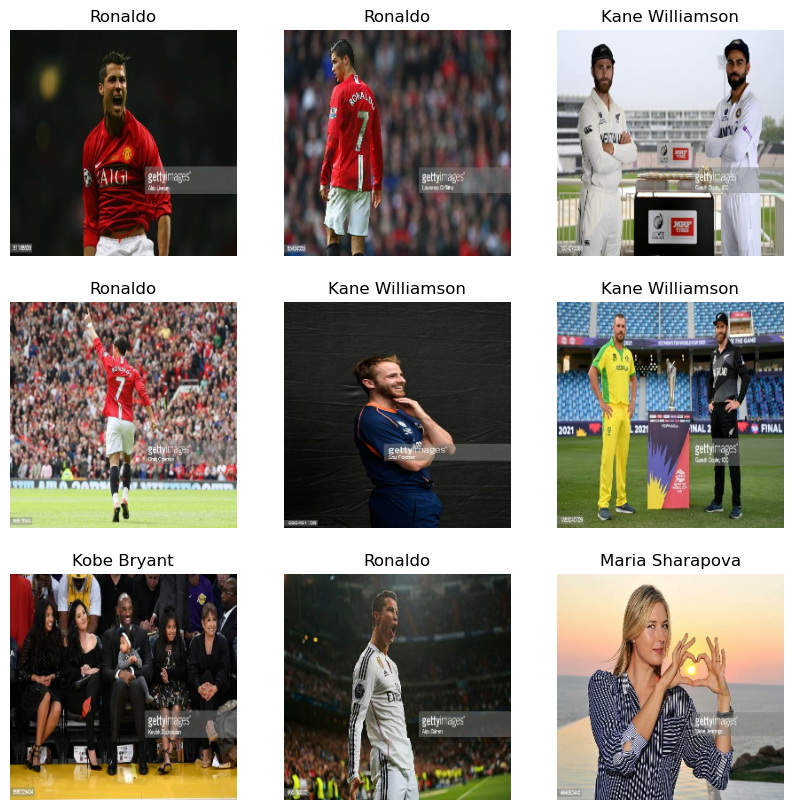

In [32]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))        
        plt.title(class_names[tf.argmax(label_batch[i], axis=0)]) # label_batch[i] es one-hot
        plt.axis("off")



<a name="4"></a>
## 4. Pre-procesamiento de datos

<a name="4.1"></a>
### 4.1. División en conjuntos de entrenamiento, validación y test

In [33]:
def train_test_split(data,train_split=.7,val_split=.15):
    
    data_size=len(data)
    
    # Define el tamaño de los conjuntos de entrenamiento, validación y prueba
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    test_size = data_size - train_size - val_size

    # Divide el conjunto de datos
    train_data = data.take(train_size)
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size + val_size).take(test_size)
    
    # retorno
    return train_data,val_data,test_data


train_data,val_data,test_data=train_test_split(data)


<a name="4.2"></a>
### 4.2. Data Augmentation

Como el dataset no es demasiado grande realizaremos un aumento de datos, en el que le aplicaremos transformaciones realistas a las imágenes (como rotaciones, cambio de brillo....). Esto ayuda a exponer al modelo a diferentes aspectos del conjunto de entrenamiento mientras que reduce el overfitting (de haberlo).


In [34]:
# defino las transformaciones
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# aplico
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y))


# para la performance
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Veamos cómo luce la aplicación de estas transformaciones:

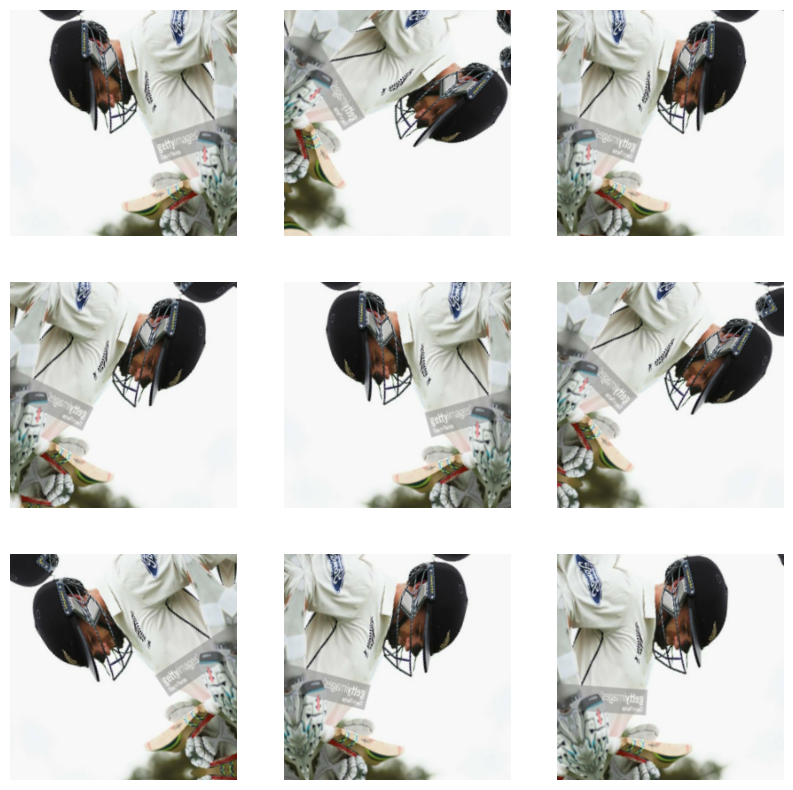

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


<a name="5"></a>
## 5. Modelo

Comenzaremos implementando el siguiente modelo:


<img src="images/Arquitectura.png"/>


<b>Nota:</b> Si bien es un modelo simple que puede implementarse con la API secuencial, se hará con la funcional para tener más praćtica con ella.



In [36]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # escalado
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    # batch norm
    tf.keras.layers.BatchNormalization()
    
    
    # capas de conv seguidas de pooling y dropout
    
    for i in range(3):
        x = layers.Conv2D(64, 3, strides=2, padding="same",activation="relu")(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.4)(x)
   
    
    # aplano    
    x = layers.Flatten()(x)
    
    # dense y dropout
    x = layers.Dense(64,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # salida
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return tf.keras.Model(inputs, outputs)

model = make_model(input_shape=input_shape, num_classes=num_classes)


Veamos un resumen de nuestro modelo:

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                             

Y ahora de forma más gráfica:

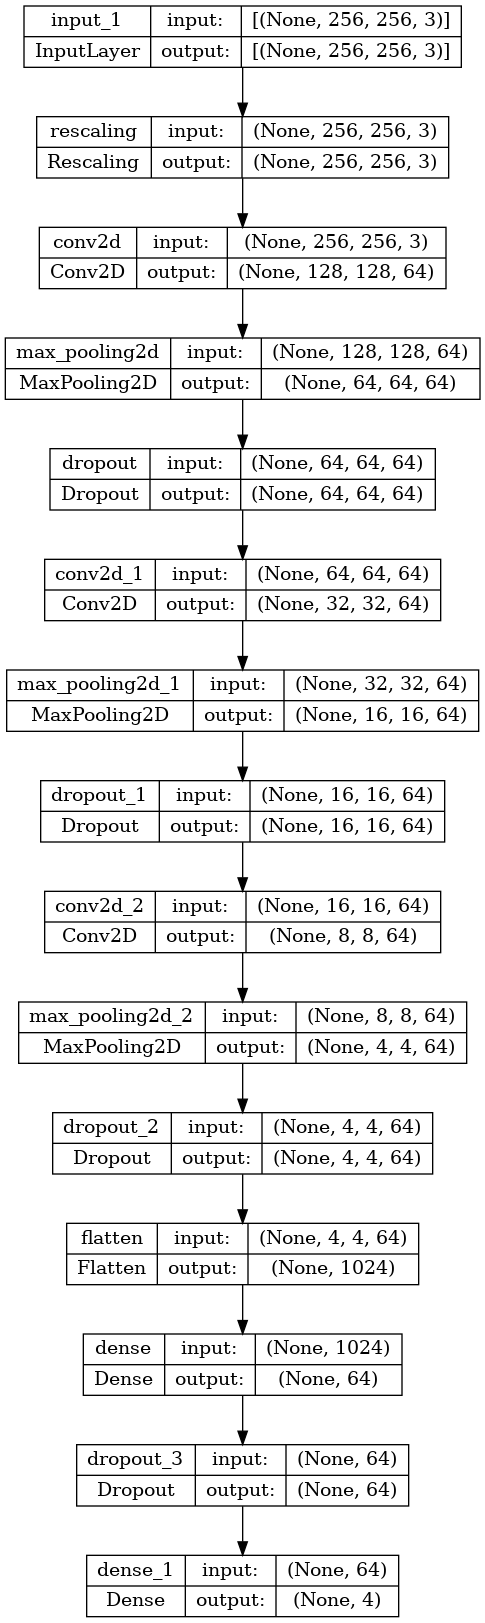

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

Compilamos y ajustamos el modelo, como callbacks usaremos EarlyStoppping (para la regularzación) y ModelCheckpoint para ir guardando los resultados intermedios. <br>

In [39]:
# definimos el número de epochs
epochs = 50

In [41]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]

history=model.fit(
                  train_data, 
                  validation_data=val_data,
                  epochs=epochs, 
                  verbose=0,
                  batch_size=batch_size,
                  callbacks=callbacks)


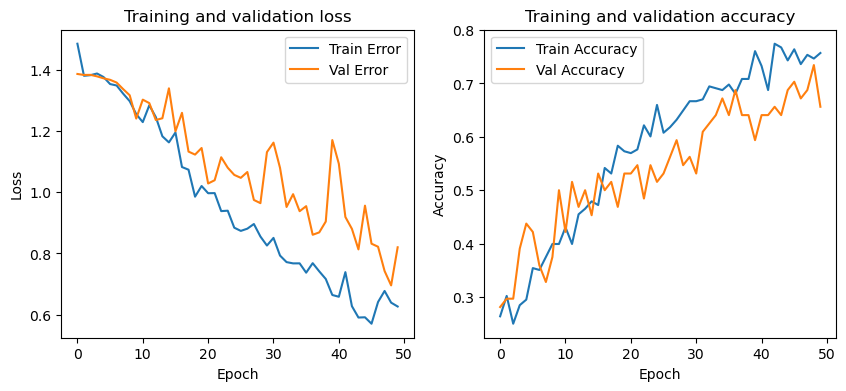

In [44]:
plot_history(history)

Vemos que si bien el modelo no es muy bueno, parece mejorar con cada epoch, por lo que entrenandolo por más tiempo podríamos lograr mejores resultados.

Antes de seguir veamos la matriz de confusión.

1/1 [==============================] - 0s 155ms/step


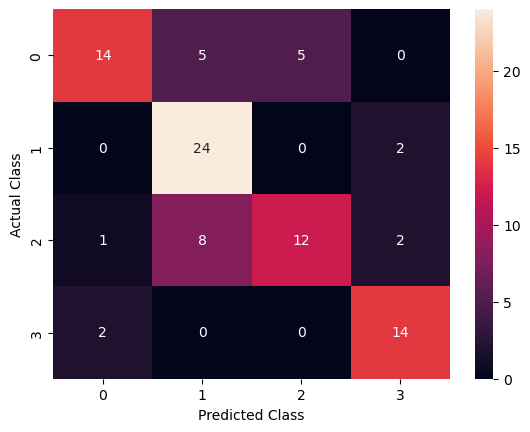

In [45]:
plot_confusion_matrix(model,test_data)


In [65]:
scores=model.evaluate(test_data)

3/3 [==============================] - 0s 85ms/step - loss: 0.6079 - accuracy: 0.7191


In [66]:
f"La performance es {round(scores[1]*100,2)}%, debemos mejorar el modelo"

'La performance es 71.91%, debemos mejorar el modelo'

<a name="6"></a>
## 6. Ajuste de hiperparámetros

Entre lo que podemos ajustar se encuentran:

- Algoritmo de optimización
- Tasa de aprendizaje
- Número de capas
- Cantidad de unidades en cada capa
- Kernel size
- Pool size
- Dropout rate
- Cantidad de epochs
- Método de inicialización
- Arquitectura de la red



Hay distintos métodos para intentar el ajuste, entre ellos:
    
- GridSearch
- RandomSearch
- Optimización bayesiana

Podemos hacerlo nosotros o utilizar herramientas que ayudan que con esta tarea, como por ejemplo: 
<a href="https://keras.io/keras_tuner/">Keras Tuner </a>.

Aquí utilizaremos Keras tuner y ajustaremos sólo algunos hiperparámetros durante algunos pocos epochs, ya que no tenemos demasiado poder computacional. <br>
Ajustaremos:
- El optimizador
- La tasa de aprendizaje
- El número de veces que repetimos el bloque conv-relu-pool-dropout
- La tasa de dropout

A su vez, usaremos el optimizador bayesiano.


In [46]:
class MyHyperModel(keras_tuner.HyperModel) :
     def build(self, hp, classes=4,input_shape=input_shape):
            
            
        inputs = tf.keras.Input(shape=input_shape)

        # escalado
        x = layers.Rescaling(1.0 / 255)(inputs)

        # batch norm
        tf.keras.layers.BatchNormalization()


        # capas de conv seguidas de pooling y dropout

        for i in range(3):
            x = layers.Conv2D(64, 3, strides=2, padding="same",activation="relu")(x)
            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
            x = layers.Dropout(hp.Choice('rate1', [0.4, 0.6]))(x)


        # aplano    
        x = layers.Flatten()(x)

        # dense y dropout
        x = layers.Dense(64,activation='relu')(x)
        x = layers.Dropout(hp.Choice('rate2', [0.5, 0.7]))(x)

        # salida
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        
        # modelo
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        
        # compilación y demás
        model.compile(optimizer=hp.Choice('optim',['adam','adamax']),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics = ['accuracy'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
        
        return model
        



In [47]:
tuner = keras_tuner.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_accuracy",
                        max_trials = 5, #max candidates to test
                        overwrite=True,
                        directory='search_dir',
                        project_name='sports_celebrities_dataset')



In [48]:
tuner.search(x=train_data, epochs=5,
             validation_data=val_data)

Trial 5 Complete [00h 00m 20s]
val_accuracy: 0.421875

Best val_accuracy So Far: 0.421875
Total elapsed time: 00h 01m 40s
INFO:tensorflow:Oracle triggered exit


In [49]:
tuner.results_summary(1)

Results summary
Results in search_dir/sports_celebrities_dataset
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
rate1: 0.4
rate2: 0.5
optim: adamax
lr: 0.003
Score: 0.421875


Obtenemos los valores de los hiperparámetros:

In [50]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model2 = tuner.hypermodel.build(best_hps)

model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                           

In [51]:

# entreno el nuevo modelo

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]

history2 = model2.fit(
                  train_data, 
                  validation_data=val_data,
                  epochs=150, 
                  verbose=0,
                  batch_size=batch_size,                  
                  callbacks=callbacks)


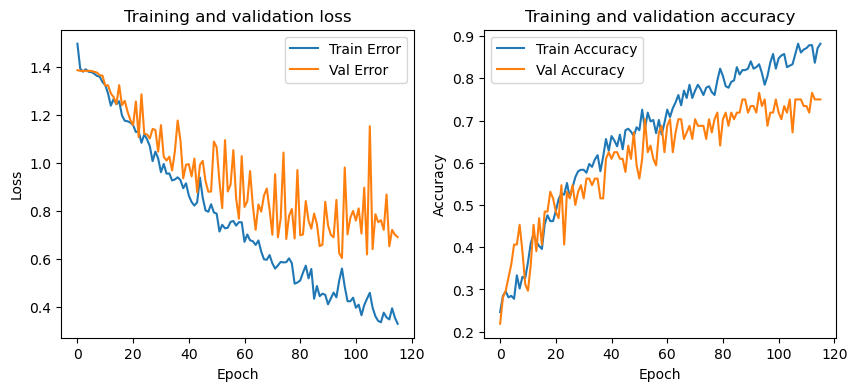

In [52]:
plot_history(history2)

1/1 [==============================] - 0s 124ms/step


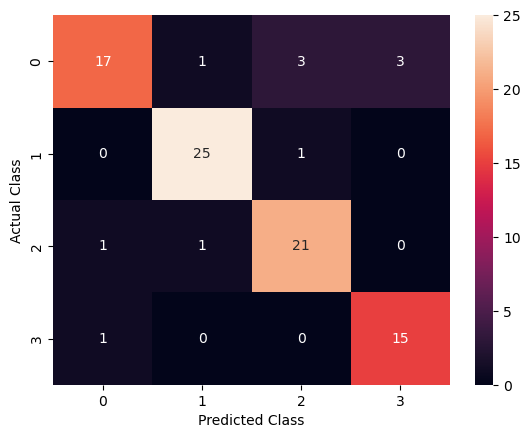

In [53]:
plot_confusion_matrix(model2,test_data)

In [54]:
scores2=model2.evaluate(test_data)


3/3 [==============================] - 0s 109ms/step - loss: 0.3900 - accuracy: 0.8764


In [55]:
f"La performance es {round(scores2[1]*100,2)}%"

'La performance es 87.64%'

Si bien mejoramos, puede verse que el modelo sigue teniendo algo de overfitting.


Trial 4 summary
Hyperparameters:
rate1: 0.4
rate2: 0.7
optim: adamax
lr: 0.003
Score: 0.390625


<a name="7"></a>
## 7. Predicciones con el modelo final

Veamos algunas predicciones con nuestras propias imágenes, previamente escribiremos una función que realice la predicción. Recuerde que nuestro modelo trabaja con imágenes a color de 256x256.

In [59]:
def predicts(model,img):
    img = np.resize(img,(256,256))
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    # respuesta
    return predicted_class,confidence

Veamos algunas predicciones sobre nuestro conjunto de test:

1/1 [==============================] - 0s 18ms/step


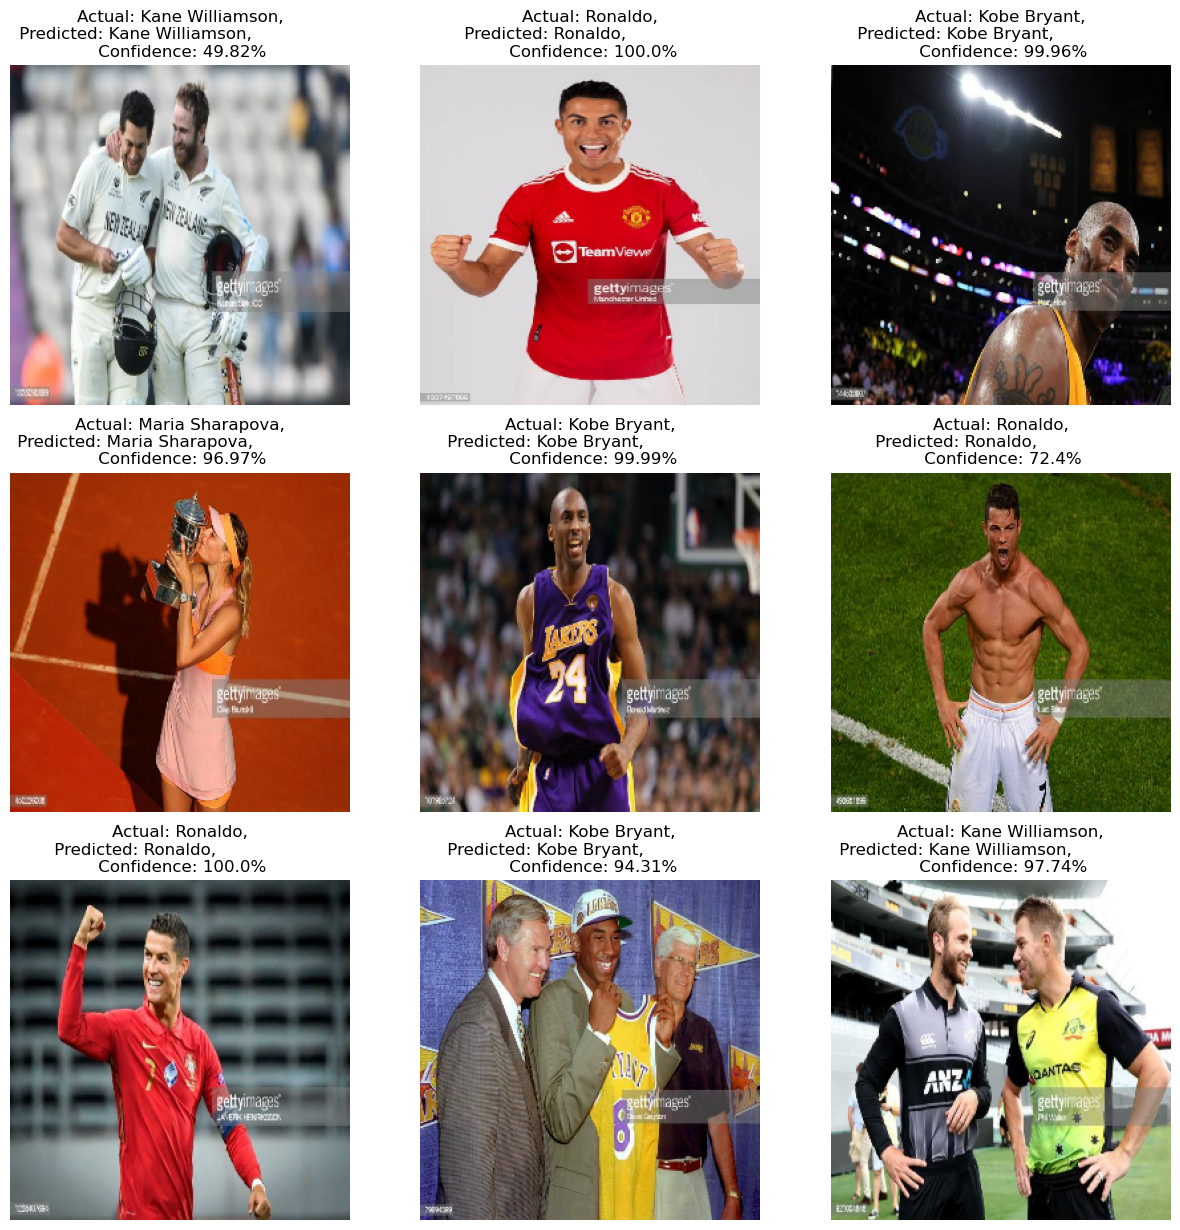

In [60]:
plt.figure(figsize=(15,15))
for images,labels in test_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predicts(model2,images[i].numpy())
        actual_class=class_names[np.argmax(labels[i])] # labels es one-hot
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\
                  \n Confidence: {confidence}%")
        plt.axis("off")


Ahora realizaremos una predicción sobre una imagen nuestra:

In [62]:
image_size = (256, 256)

img = keras.utils.load_img(
    "my_test_images/maria.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model2.predict(img_array)

indice_max = np.argmax(predictions[0])

prob_class = predictions[0][indice_max]
predicted_class=class_names[indice_max]


print(f"Se predice {predicted_class} con una confianza de {100*prob_class:.2f}%")



1/1 [==============================] - 0s 23ms/step
Se predice Maria Sharapova con una confianza de 81.19%


<a name="8"></a>
## 8. Guardando el modelo

Ahora guardaremos el modelo, que consiste de múltiples componentes:
    
- Su arquitectura 
- Los pesos
- El optimizador
- El conjunto de métricas y pérdidas

In [63]:
model.save('model2.keras') 

Para cargarlo simplemente escribimos:

In [64]:
model = keras.models.load_model('model2.keras')

<a name="9"></a>
## 9. Conclusiones

Se entreno un modelo para la clasificación de imágenes de celebridades del deporte con una precisión del 80%.
Para lograr una mejor performance se pueden probar más combinaciones de hiperparámetros y conseguir una mayor cantidad de datos (es un dataset más bien pequelo con el cual se trabajó).